In [8]:
import sys, logging
from pathlib import Path
import pandas as pd
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Define the project root and add it to the path so we can run HECTRE.
PROJ_ROOT = Path('..', '..').resolve()
sys.path.insert(0, str(PROJ_ROOT))

In [3]:
# Reload the notebook if imported modules are modified.
%load_ext autoreload
%autoreload 2

In [4]:
# Import HECTRE and disable logging. We'll be creating a custom report in this notebook.
from hectre.metrics import accuracy
logging.disable()

In [5]:
TESTING=False
TEST_ROOT = Path(PROJ_ROOT, 'hectre', 'tests', 'test_data')
control_cdfs = Path(TEST_ROOT, 'cdfs', 'eval_report').iterdir()
eval_data = {}
for control_cdf_path in control_cdfs:
    slug = control_cdf_path.stem.lower()
    pdf_path = Path(TEST_ROOT, slug + '.pdfdata')
    pdf_path_input = str(pdf_path)
    picos_input = "EASI-50;EASI-75;EASI-90"
    cdf_path_input = str(control_cdf_path)
    control_cdf = pd.read_csv(cdf_path_input)
    if TESTING:
        test_cdf = pd.read_csv(Path(TEST_ROOT, 'cdfs', 'eval_report_test_cdfs', control_cdf_path.name).resolve())
    else:
        test_cdf = accuracy.accuracy_extract_test(pdf_path_input, picos_input)
    acc = accuracy.cdf_accuracy(
        test_cdf,
        control_cdf,
        slug
    )
    eval_data[slug] = acc

In [6]:
# Stacked DF stylization
def set_index_colors(df, index_styles):
    # DataFrame of styles
    df1 = pd.DataFrame('', index=df.index, columns=df.columns)
    for index_style in index_styles:
        mask = df.index.isin([index_style['value']], level=index_style['name'])
        df1[mask] = f"background-color: {index_style['color']};"
    return df1

# HECTRE Performance Evaluation Report

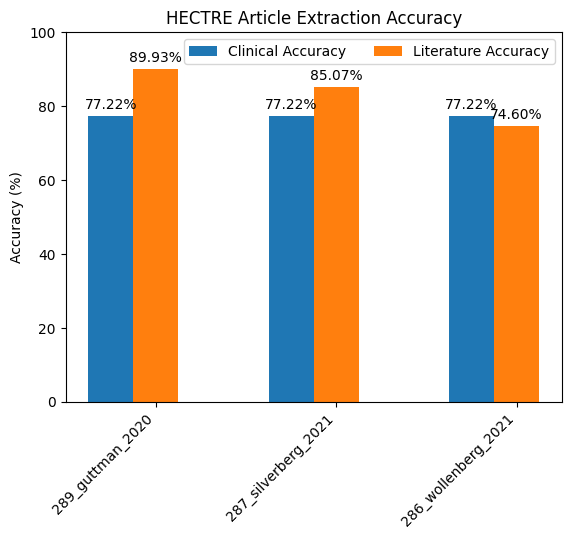

In [27]:
# Article slugs.
articles = ()
# stat_name: stat values.
stats = {}

for slug, data in eval_data.items():
    clin_values = extraction['comparison']['comp_values_clin']
    clinical_accuracy_data = clin_values[(clin_values.index.get_level_values('has_match') == 1)]
    clinical_accuracy = clin_values_drop_unmatched.mean(axis=None)
    literature_accuracy = data['lit_acc_pct']
    stats['Clinical Accuracy'] = stats.get('Clinical Accuracy', ()) + (clinical_accuracy,)
    stats['Literature Accuracy'] = stats.get('Literature Accuracy', ()) + (literature_accuracy,)
    articles += (slug,)
    

x = np.arange(len(eval_data.items()))  # Article index on x-axis.
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()
fmt = lambda x: '{:.2f}%'.format(x)
for stat, data in stats.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, data, width, label=stat)
    ax.bar_label(rects, padding=3, fmt=fmt)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title('HECTRE Article Extraction Accuracy')
ax.set_xticks(x + width, articles, rotation=45, ha='right')
ax.legend(loc='best', ncols=3)
ax.set_ylim(0, 100)

plt.show()

In [7]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.multi_sparse', False)
for slug, extraction in eval_data.items():
    display(Markdown(f'## {slug}'))
    display(Markdown(f"**Control rows matched by test output:** {extraction['matched_control_rows']} of {extraction['num_control_rows']}"))
    display(Markdown(f"**Literature data accuracy:** {extraction['lit_acc_pct']:.2f}%"))
    clin_values = extraction['comparison']['comp_values_clin']
    display(Markdown(f"**Clinical data accuracy:** {clin_values.mean(axis=None):.2f}%"))
    clin_values_drop_unmatched = clin_values[(clin_values.index.get_level_values('has_match') == 1)]
    display(Markdown(f"**Clinical data accuracy (drop unmatched):** {clin_values_drop_unmatched.mean(axis=None):.2f}%"))
    display(Markdown("### Test Output vs. Control Output and their Similarity"))
    index_styles = [
        {
            'name': 'sample',
            'value': 'similarity',
            'color': 'orange'
        },
        {
            'name': 'sample',
            'value': 'test',
            'color': 'skyblue'
        },
        {
            'name': 'sample',
            'value': 'control',
            'color': 'pink'
        },
        
    ]
    stacked_df = extraction['comparison']['stacked_df']
    stacked_df = stacked_df.style.apply(set_index_colors,axis=None, index_styles=index_styles)
    with pd.option_context('display.multi_sparse',False):
        display(stacked_df)

## 289_guttman_2020

**Control rows matched by test output:** 11 of 68

**Literature data accuracy:** 89.93%

**Clinical data accuracy:** 14.48%

**Clinical data accuracy (drop unmatched):** 89.52%

### Test Output vs. Control Output and their Similarity

## 287_silverberg_2021

**Control rows matched by test output:** 9 of 84

**Literature data accuracy:** 85.07%

**Clinical data accuracy:** 8.63%

**Clinical data accuracy (drop unmatched):** 80.52%

### Test Output vs. Control Output and their Similarity

## 286_wollenberg_2021

**Control rows matched by test output:** 15 of 178

**Literature data accuracy:** 74.60%

**Clinical data accuracy:** 6.51%

**Clinical data accuracy (drop unmatched):** 77.22%

### Test Output vs. Control Output and their Similarity